## Load Libraries

In [1]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# # Install TensorFlow
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

'2.0.0-beta1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [4]:
DATA_DIR = 'data'
IMAGE_WIDTH = 120
IMAGE_HEIGHT = 120
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

## Load and preprocess data


In [5]:
import pathlib
data_root = pathlib.Path(DATA_DIR)
print(data_root)

data


In [6]:
for item in data_root.iterdir():
  print(item)

data/Archive.zip
data/train
data/test


In [7]:
import random
train_image_paths = list(data_root.glob('train/*'))
train_image_paths = [str(path) for path in train_image_paths]
random.shuffle(train_image_paths)

test_image_paths = list(data_root.glob('test/*'))
test_image_paths = [str(path) for path in test_image_paths]
random.shuffle(test_image_paths)

# Count all images
image_count = len(train_image_paths)
print(image_count)
print(len(test_image_paths))

25000
12500


### Create datasets from directories

In [8]:
# Get labels from files name
def get_image_labels(file_dir):
  image_labels = []

  for item in data_root.glob(file_dir):

    if item.is_file() and item.name.find('c'):
      label = 0
    else:
      label = 1

    image_labels.append(label)
    
  return image_labels

In [9]:
train_image_labels = get_image_labels('train/*')
print(train_image_labels[0:10])

[1, 0, 0, 1, 1, 0, 0, 1, 0, 1]


In [10]:
# import pandas as pd

# def get_images_df(file_dir):
#   labels = []
#   files = os.listdir(file_dir) 
  
#   for file_name in files:
#     label = file_name.split('.')[0]
    
# #     if label == 'cat':
# #       labels.append(0)
# #     else:
# #       labels.append(1)
    
#     labels.append(label)
  
#   df = pd.DataFrame({
#     'file_name': files,
#     'category': labels
#   })
  
#   return df

In [11]:
# df_train_images = get_images_df(DATA_DIR + '/train')

In [12]:
# df_train_images.head(5)

### Train - Test Splitting

In [13]:
# from sklearn.model_selection import train_test_split

# # df_train, df_test = train_test_split(df_train_images, test_size=0.1, random_state=42)
# df_train, df_validation = train_test_split(df_train_images, test_size=0.2, random_state=42)

# # df_test = df_test.reset_index(drop=True)
# df_train = df_train.reset_index(drop=True)
# df_validation = df_validation.reset_index(drop=True)

In [14]:
# print(len(df_train), len(df_validation))

In [15]:
# print(df_train.shape)

### Print out some images

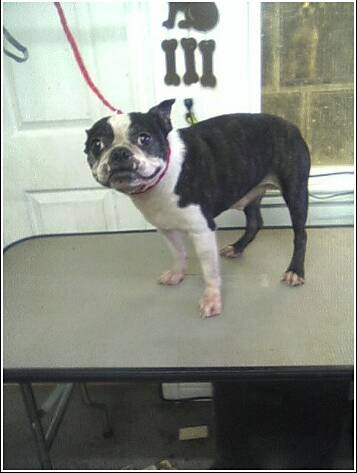

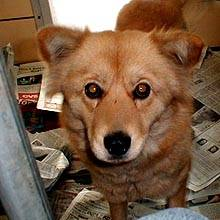

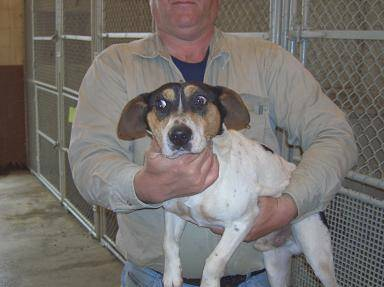

In [16]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(train_image_paths)
    display.display(display.Image(image_path))
    print()

## Mini Batch Processing

In [17]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    image /= 255.0  # normalize to [0,1] range
    image = 2*image-1  # normalize to [-1,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [18]:
# Slicing the array of strings, results in a dataset of strings:
path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)

In [19]:
ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((120, 120, 3), ()), types: (tf.float32, tf.int32)>

In [20]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE


# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.int32)>

In [21]:
# df_train.shape

### Image Preprocessing

In [22]:
# # Preprocess Train dataset
# train_datagen = ImageDataGenerator(
#         rotation_range=15,
#         rescale=1./255,
#         shear_range=0.1,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1)

# train_generator = train_datagen.flow_from_dataframe(
#         df_train,
#         directory=DATA_DIR + '/train/',
#         x_col='file_name',
#         y_col='category',
#         target_size=IMAGE_SIZE,
#         batch_size=15,
#         class_mode='categorical')

# # Preprocess Validation dataset
# validation_datagen = ImageDataGenerator(rescale=1./255)

# validation_generator = validation_datagen.flow_from_dataframe(
#         df_validation,
#         directory=DATA_DIR + '/train/',
#         x_col='file_name',
#         y_col='category',
#         target_size=IMAGE_SIZE,
#         batch_size=15,
#         class_mode='categorical')

In [23]:
# IMAGE_SIZE

In [24]:
# df_sample = df_train.sample(1).reset_index(drop=True)
# sample_generator = train_datagen.flow_from_dataframe(
#     df_sample,
#     directory=DATA_DIR + '/train/',
#     x_col='file_name',
#     y_col='category',
#     target_size=IMAGE_SIZE,
#     seed=42,
#     shuffle=True,
#     class_mode='categorical'
# )

In [25]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in sample_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

## Create Model

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def create_model():
  model = tf.keras.Sequential()
  
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

#   model.add(Conv2D(128, (3, 3), activation='relu'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes
  
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [27]:
model = create_model()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 118, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0

### Create Checkpoint

In [29]:
checkpoint_path = "static/models/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by default it saves the weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [30]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
# #     EarlyStopping(patience=10, verbose=1),
# #     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('checkpoints/model.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

### Train model

In [31]:
steps_per_epoch=tf.math.ceil(len(train_image_paths)/BATCH_SIZE).numpy()
history = model.fit(ds, epochs=20, steps_per_epoch=steps_per_epoch, callbacks=[cp_callback])

Epoch 1/20


W0823 06:46:09.321191 140099126875904 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


781/782 [============================>.] - ETA: 0s - loss: 0.8111 - accuracy: 0.4961
Epoch 00001: saving model to static/models/checkpoints/cp.ckpt
782/782 [==============================] - 631s 807ms/step - loss: 0.8109 - accuracy: 0.4961
Epoch 2/20
781/782 [============================>.] - ETA: 0s - loss: 0.6995 - accuracy: 0.5116
Epoch 00002: saving model to static/models/checkpoints/cp.ckpt
782/782 [==============================] - 440s 563ms/step - loss: 0.6995 - accuracy: 0.5118
Epoch 3/20
781/782 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.5108
Epoch 00003: saving model to static/models/checkpoints/cp.ckpt
782/782 [==============================] - 437s 559ms/step - loss: 0.6994 - accuracy: 0.5108
Epoch 4/20
781/782 [============================>.] - ETA: 0s - loss: 0.6994 - accuracy: 0.5051
Epoch 00004: saving model to static/models/checkpoints/cp.ckpt
782/782 [==============================] - 440s 563ms/step - loss: 0.6994 - accuracy: 0.5050
Epo

In [33]:
model.save('models/my_model.h5')

In [32]:
# total_train = df_train.shape[0]
# total_validation = df_validation.shape[0]

# print(total_train, total_validation)

# STEP_SIZE_TRAIN=total_train//train_generator.batch_size
# STEP_SIZE_VALID=total_validation//validation_generator.batch_size

# print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

# model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=validation_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     callbacks=callbacks,
#                     epochs=5)